**Necessary imports**

In [94]:
import os
import wrds
import pandas as pd
import warnings
from datetime import datetime, timedelta
import numpy as np
from functools import reduce
warnings.filterwarnings("ignore")

**STEP 1 : data collection from wrds**

In [95]:
user_name = os.getenv('WRDS_USERNAME')
db = wrds.Connection(wrds_username=user_name)

Loading library list...
Done


In [96]:
#---------------------------------------------
# Risk Free Rate 
#---------------------------------------------
Rf=db.raw_sql("""select  mcaldt,tmytm 
           from crsp.tfz_mth_rf            
            where kytreasnox = 2000001 
           and mcaldt>='2002-03-01'
            and mcaldt<='2024-12-31'""", date_cols=['mcaldt'])
Rf['tmytm']=Rf['tmytm']/12/100


Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})
Rf['date'] = Rf['date'].dt.to_period('M').dt.to_timestamp('M') 
Rf.set_index('date', inplace = True)

#Get the crsp value-weighted return index
query_crsp = """select  date,vwretd from crsp.msi 
                where date>='2002-03-01' and date<='2024-12-31'"""

crsp_returns = db.raw_sql(query_crsp,  date_cols=['date'])
crsp_returns = crsp_returns.rename(columns={'vwretd': 'us_return'})
crsp_returns.to_csv('data/crsp_return.csv')
Rf.to_csv('data/t_bills_one_month.csv')

In [136]:
Rf = pd.read_csv('data/t_bills_one_month.csv')
Rf.set_index('date', inplace = True)
Rf.index = pd.to_datetime(Rf.index)

In [98]:
crsp_returns = pd.read_csv('data/crsp_return.csv')
crsp_returns = crsp_returns.drop(columns= 'Unnamed: 0')#D'ou ca vient ???
crsp_returns['date'] = pd.to_datetime(crsp_returns['date'])
crsp_returns['date'] = crsp_returns['date'].dt.to_period('M').dt.to_timestamp('M') 

In [99]:
#Interest Rates: 3-Month or 90-Day Rates and Yields: Interbank Rates
def load_and_prepare_ir3(filepath, rename_dict):
    df = pd.read_csv(filepath).rename(columns=rename_dict)
    df['date'] = pd.to_datetime(df['date'])    
    df['date'] = df['date'] - timedelta(days=1) 
    df['date'] = df['date'].dt.to_period('M').dt.to_timestamp('M') 
    df[df.columns[1]] /= 100
    return df.set_index('date')                 

# Load each series using the helper
ir3_japan = load_and_prepare_ir3("data/IR3TIB01JPM156N.csv", {"observation_date": "date", "IR3TIB01JPM156N": "ir3_jpn"})
ir3_fra   = load_and_prepare_ir3("data/IR3TIB01FRM156N.csv", {"observation_date": "date", "IR3TIB01FRM156N": "ir3_fra"})
ir3_gb    = load_and_prepare_ir3("data/IR3TIB01GBM156N.csv", {"observation_date": "date", "IR3TIB01GBM156N": "ir3_gb"})
ir3_us    = load_and_prepare_ir3("data/IR3TIB01USM156N.csv", {"observation_date": "date", "IR3TIB01USM156N": "ir3_us"})
ir3_aus   = load_and_prepare_ir3("data/IR3TIB01AUM156N.csv", {"observation_date": "date", "IR3TIB01AUM156N": "ir3_aus"})
ir3_ch    = load_and_prepare_ir3("data/IR3TIB01CHM156N.csv", {"observation_date": "date", "IR3TIB01CHM156N": "ir3_ch"})
ir3_deu   = load_and_prepare_ir3("data/IR3TIB01DEM156N.csv", {"observation_date": "date", "IR3TIB01DEM156N": "ir3_deu"})



# JPY: DEXJPUS (JPY per 1 USD) 
df_jpy = pd.read_csv("data/EXJPUS.csv").rename(columns={"observation_date": "date"})

df_jpy.name = "JPY_per_USD"

# CHF: DEXSZUS (CHF per 1 USD)
df_chf = pd.read_csv("data/EXSZUS.csv").rename(columns={"observation_date": "date"})
df_chf.name = "CHF_per_USD"

# AUD: DEXUSAL (USD per 1 AUD) 
df_aud = pd.read_csv("data/EXUSAL.csv").rename(columns={"observation_date": "date"})
df_aud["AUD_per_USD"] = 1 / df_aud["EXUSAL"]


# EUR: DEXUSEU (USD per 1 EUR) 
df_eur = pd.read_csv("data/EXUSEU.csv").rename(columns={"observation_date": "date"})
df_eur["EUR_per_USD"] = 1 / df_eur["EXUSEU"]

# GBP: DEXUSUK (USD per 1 GBP) 
df_gbp = pd.read_csv("data/EXUSUK.csv").rename(columns={"observation_date": "date"})
df_gbp["GBP_per_USD"] = 1 / df_gbp["EXUSUK"]

files = {
    'jpn': 'data/jpn.csv',
    'aus': 'data/aus.csv',
    'deu': 'data/deu.csv',
    'fra': 'data/fra.csv',
    'ch':  'data/swz.csv',
    'gb':  'data/uk.csv'
}

country_data = {}

for code, path in files.items():
    df = pd.read_csv(path)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.to_period('M').dt.to_timestamp('M') 
 
    return_col = [col for col in df.columns if col != 'date'][0]
    df = df.rename(columns={return_col: f'{code}_return'})
    country_data[code] = df



In [100]:
foreign_to_usd = pd.concat([
    df_jpy['EXJPUS'].rename("JPY_per_USD"),
    df_chf['EXSZUS'].rename("CHF_per_USD"),
    df_aud['AUD_per_USD'].rename("AUD_per_USD"),
    df_eur['EUR_per_USD'].rename("EUR_per_USD"),
    df_gbp['GBP_per_USD'].rename("GBP_per_USD")
], axis=1)
foreign_to_usd.index = pd.to_datetime(foreign_to_usd.index)
foreign_to_usd.index = foreign_to_usd.index - timedelta(days=1)
foreign_to_usd.index = pd.to_datetime(df_jpy['date']).dt.to_period('M').dt.to_timestamp('M') 

**Visualizing the data**

<Figure size 800x400 with 0 Axes>

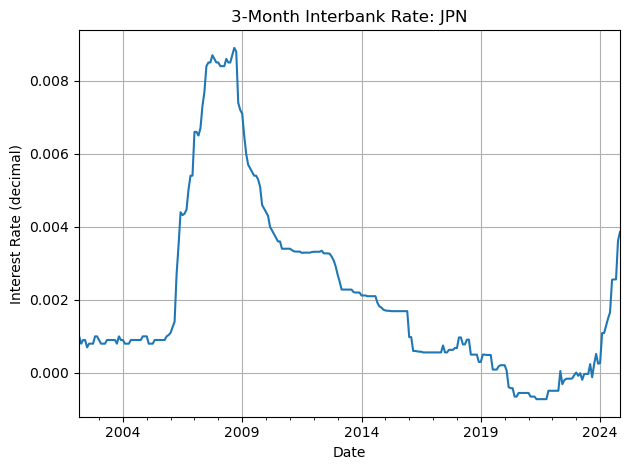

<Figure size 800x400 with 0 Axes>

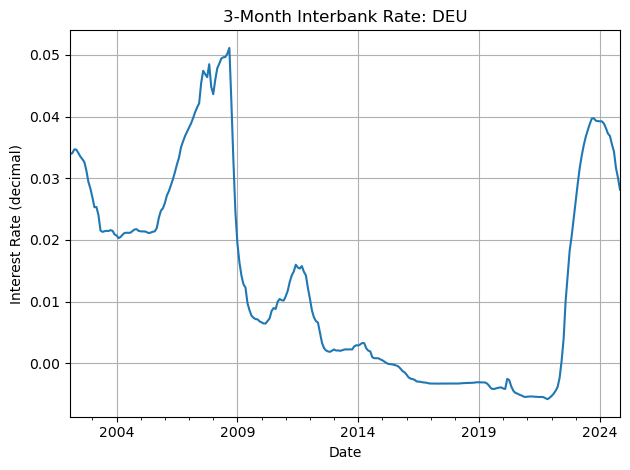

<Figure size 800x400 with 0 Axes>

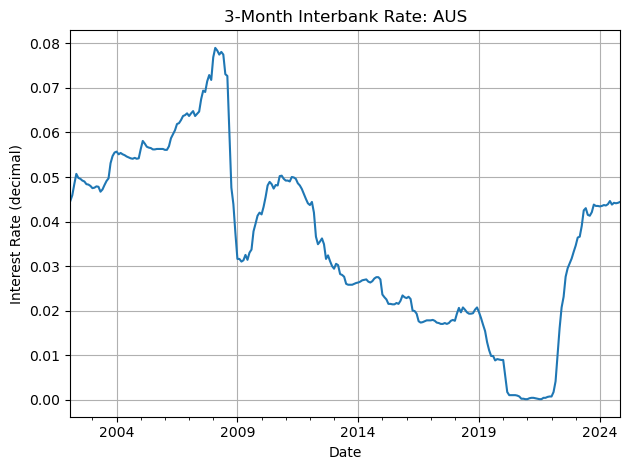

<Figure size 800x400 with 0 Axes>

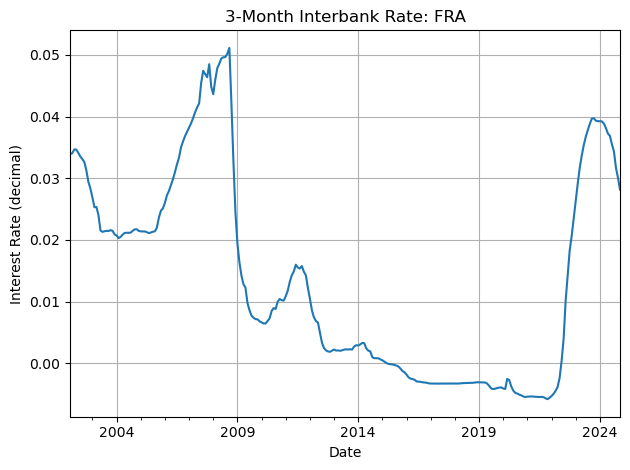

<Figure size 800x400 with 0 Axes>

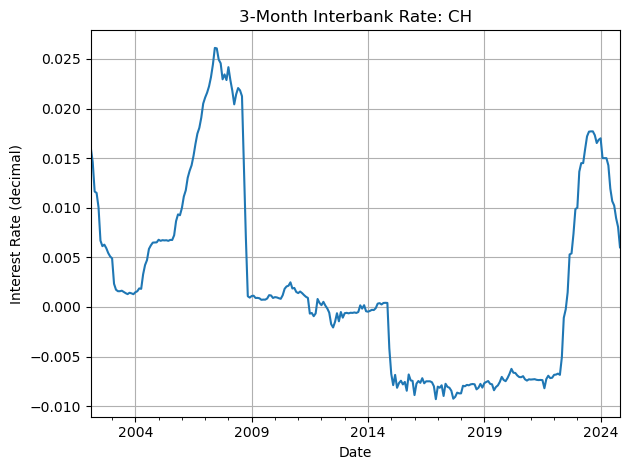

<Figure size 800x400 with 0 Axes>

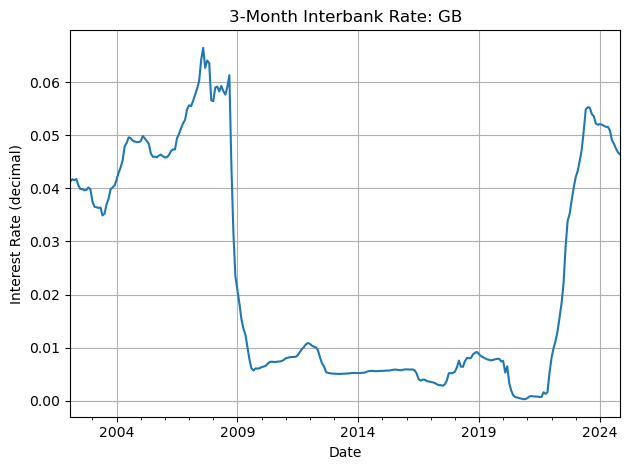

<Figure size 800x400 with 0 Axes>

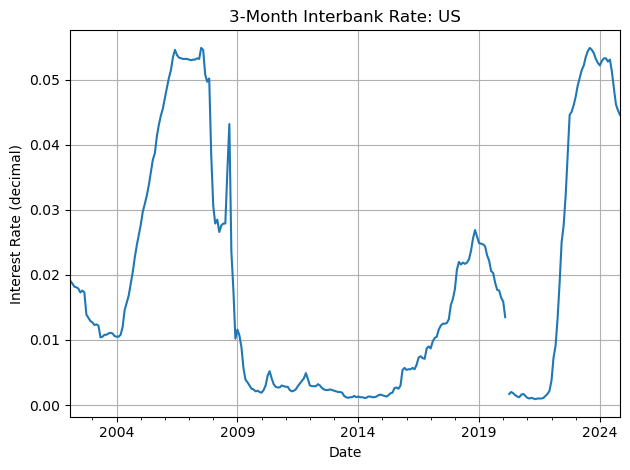

In [101]:
import matplotlib.pyplot as plt
ir3_data = {
    'jpn': ir3_japan,
    'deu': ir3_deu,
    'aus': ir3_aus,
    'fra': ir3_fra,
    'ch': ir3_ch,
    'gb': ir3_gb,
    'us' : ir3_us
}

for country, df in ir3_data.items():
    plt.figure(figsize=(8, 4))
    df.plot(y=f'ir3_{country}', legend=False)
    plt.title(f'3-Month Interbank Rate: {country.upper()}')
    plt.xlabel('Date')
    plt.ylabel('Interest Rate (decimal)')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

**We observe a missing value in 2020 for the us interbank rate, to replace it we will use interpolation**

In [102]:
ir3_data['us'] = ir3_us.interpolate(method='time')

<Axes: xlabel='date'>

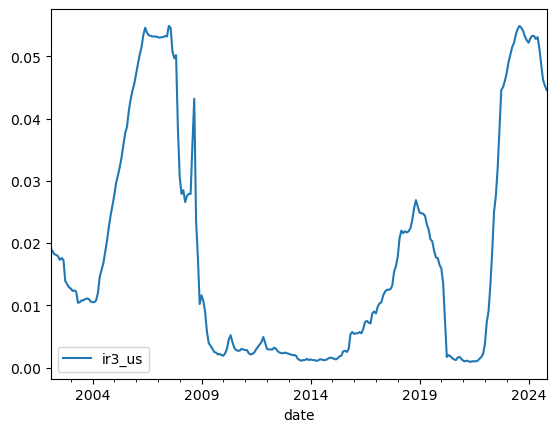

In [103]:
ir3_data['us'].plot()

**Now it is interpolated, and all our data is continuous ! **

In [104]:
#Merge all the interbank together 
ir3_all = pd.concat(
    [df.rename(columns={df.columns[0]: f'ir3_{code}'}) for code, df in ir3_data.items()],
    axis=1,
    join='outer'
)


**Let's plot the exchange rate**

<Figure size 1000x400 with 0 Axes>

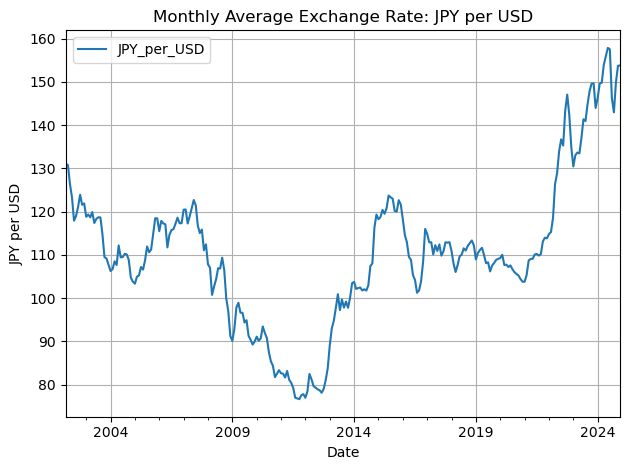

<Figure size 1200x600 with 0 Axes>

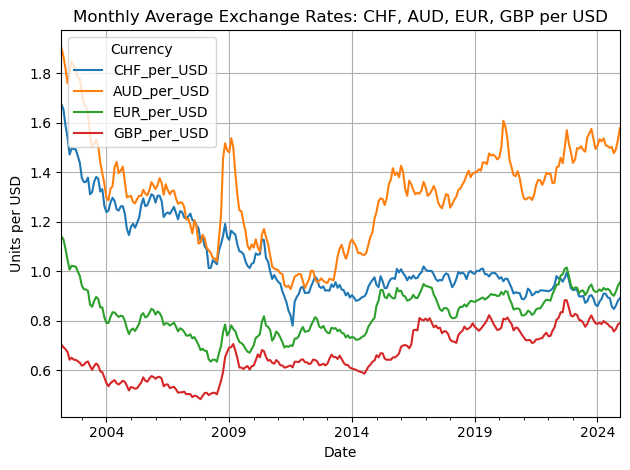

In [105]:
# Separate JPY from others
monthly_jpy = foreign_to_usd[['JPY_per_USD']]
monthly_others = foreign_to_usd.drop(columns='JPY_per_USD')


plt.figure(figsize=(10, 4))
monthly_jpy.plot()
plt.title("Monthly Average Exchange Rate: JPY per USD")
plt.xlabel("Date")
plt.ylabel("JPY per USD")
plt.grid(True)
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))
monthly_others.plot()
plt.title("Monthly Average Exchange Rates: CHF, AUD, EUR, GBP per USD")
plt.xlabel("Date")
plt.ylabel("Units per USD")
plt.grid(True)
plt.legend(title="Currency", loc="upper left")
plt.tight_layout()
plt.show()

In [106]:
foreign_to_usd

,JPY_per_USD,CHF_per_USD,AUD_per_USD,EUR_per_USD,GBP_per_USD
date,,,,,
2002-03-31,131.0610,1.6743,1.902588,1.140771,0.702741
2002-04-30,130.7718,1.6542,1.868460,1.128668,0.693049
2002-05-31,126.3750,1.5889,1.818843,1.090513,0.685025
2002-06-30,123.2905,1.5399,1.759944,1.045916,0.673991
2002-07-31,117.8991,1.4718,1.805706,1.006543,0.642467
...,...,...,...,...,...
2024-08-31,146.2641,0.8579,1.501953,0.907441,0.772499
2024-09-30,142.9540,0.8472,1.477105,0.900576,0.756487
2024-10-31,149.8909,0.8613,1.492537,0.917852,0.766695


### Foreign Index Return in USD

The formula to convert a foreign index return to USD is:

$$
R_{DC} = (1 + R_{FC}) \cdot (1 + R_{FX}) - 1
$$

Where:

- \( R_{DC} \): Return in domestic currency (USD)  
- \( R_{FC} \): Return in foreign currency  
- \( R_{FX} \): Return on the exchange rate (foreign per USD)


Returns can be expressed as $\log{\frac{R_{t}}{R_t - 1}}$

In [107]:
usd_to_foreign = 1 / foreign_to_usd
usd_to_foreign.columns = [f'USD_PER_{col.split("_")[0]}' for col in usd_to_foreign.columns]

In [108]:
country_data['jpn']

,jpn_return,date,country,currency,mportret,mportretx
0,JPN,2002-03-31,JAPAN,JPY,0.053119,0.048294
1,JPN,2002-04-30,JAPAN,JPY,0.020586,0.020574
2,JPN,2002-05-31,JAPAN,JPY,0.035987,0.035920
3,JPN,2002-06-30,JAPAN,JPY,-0.083764,-0.083961
4,JPN,2002-07-31,JAPAN,JPY,-0.057720,-0.057960
...,...,...,...,...,...,...
268,JPN,2024-07-31,JAPAN,JPY,-0.004150,-0.004275
269,JPN,2024-08-31,JAPAN,JPY,-0.024404,-0.024809
270,JPN,2024-09-30,JAPAN,JPY,-0.014245,-0.023069
271,JPN,2024-10-31,JAPAN,JPY,0.016975,0.016898


In [109]:
def convert_foreign_to_usd(ret_foreign_currency, ret_fx):
    return (1 + ret_foreign_currency) * (1 + ret_fx) - 1

# Step 1: Compute FX returns
ret_exchange_rate = usd_to_foreign / usd_to_foreign.shift(1) -1
ret_exchange_rate.dropna(inplace=True)
ret_exchange_rate.sort_index(inplace=True)


def process_country(df, fx_column, ret_exchange_rate):
    df = df[['date', 'country', 'mportret']].copy()
    df.dropna(subset=['mportret'], inplace=True)

    # Merge on date to align
    df = df.merge(ret_exchange_rate[[fx_column]], how='inner', left_on='date', right_index=True)

    # Convert to USD returns
    df['mportret'] = convert_foreign_to_usd(df['mportret'], df[fx_column])
    df = df[['date', 'country', 'mportret']]
    return df


jpn = process_country(country_data['jpn'], 'USD_PER_JPY', ret_exchange_rate)
aus = process_country(country_data['aus'], 'USD_PER_AUD', ret_exchange_rate)
deu = process_country(country_data['deu'], 'USD_PER_EUR', ret_exchange_rate)
fra = process_country(country_data['fra'], 'USD_PER_EUR', ret_exchange_rate)
ch  = process_country(country_data['ch'],  'USD_PER_CHF', ret_exchange_rate)
gb  = process_country(country_data['gb'],  'USD_PER_GBP', ret_exchange_rate)


crsp_returns['country'] = 'US'
crsp_returns.rename(columns={'us_return': 'mportret'}, inplace=True)
us = crsp_returns[['date', 'country', 'mportret']].copy()
us = us.dropna().iloc[1:-1]  # Drop first and last row

# Combine all
merged_all = pd.concat([jpn, aus, deu, fra, ch, gb, us], axis=0, ignore_index=True)


In [110]:
merged_all['date'] = pd.to_datetime(merged_all['date'])
merged_all['date'] = merged_all['date'].dt.to_period('M').dt.to_timestamp('M')

**PROBLEM WITH AUStralia We neED to find what. The following is to see why** 

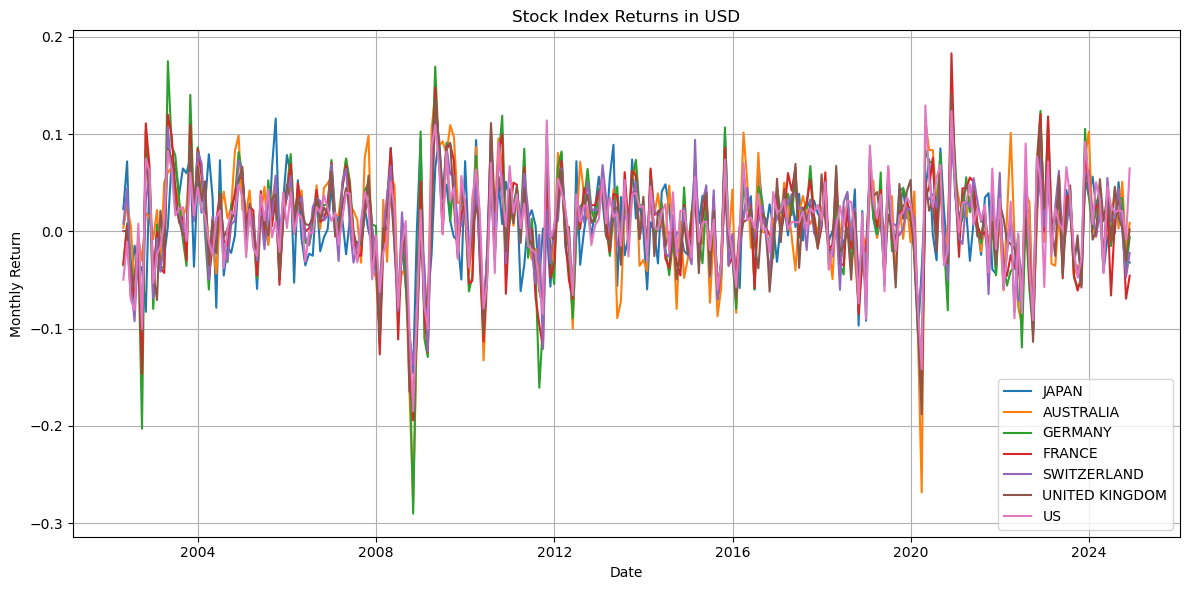

In [111]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
for country in merged_all['country'].unique():
    subset = merged_all[merged_all['country'] == country]
    plt.plot(subset['date'], subset['mportret'], label=country)

plt.title('Stock Index Returns in USD')
plt.xlabel('Date')
plt.ylabel('Monthly Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [112]:
import matplotlib.pyplot as plt

def compare_countries(merged_all, country1, country2, return_type='mportret'):
    """
    Plot cumulative returns in USD of two countries from the merged_all dataframe.
    
    Parameters:
        merged_all (DataFrame): Combined dataset with 'date', 'country', and return columns.
        country1, country2 (str): Country names to compare (must match 'country' column values).
        return_type (str): Either 'mportret' (unhedged) or 'mportretx' (hedged).
    """
    df1 = merged_all[merged_all['country'] == country1][['date', return_type]].copy()
    df2 = merged_all[merged_all['country'] == country2][['date', return_type]].copy()

    # Merge on date to ensure strict alignment
    df = df1.merge(df2, on='date', suffixes=(f'_{country1}', f'_{country2}'))

    # Compute cumulative returns
    df[f'cumulative_{country1}'] = (1 + df[f'{return_type}_{country1}']).cumprod()
    df[f'cumulative_{country2}'] = (1 + df[f'{return_type}_{country2}']).cumprod()

    # Plot
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df[f'cumulative_{country1}'], label=country1, linewidth=2)
    plt.plot(df['date'], df[f'cumulative_{country2}'], label=country2, linewidth=2)
    plt.title(f'Cumulative Return in USD: {country1} vs {country2}')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return (Start = 1)')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


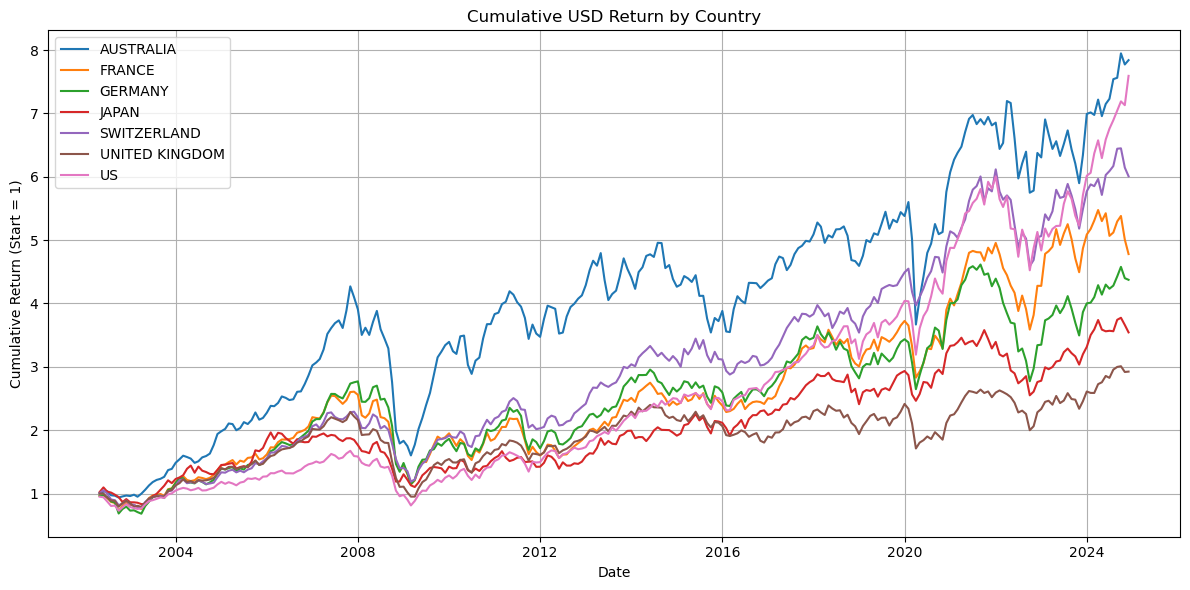

In [113]:
merged_all_filtered = merged_all[merged_all['date'] > '2002-01-01']

plt.figure(figsize=(12, 6))

# Plot cumulative returns for each country
for country, group in merged_all_filtered.groupby('country'):
    cumulative = (1 + group['mportret']).cumprod()
    plt.plot(group['date'], cumulative, label=country)

plt.title('Cumulative USD Return by Country')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Start = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Currency-Hedged Excess Return in USD

The formula for the **excess return** in USD from a $1 investment in the Euro-currency hedged via shorting the foreign currency is:

$$
X_{t+1}^{\text{EU}} = \frac{S_{t+1}}{S_t}(1 + r^{\text{EU}}) - (1 + r^{\text{US}})
$$

Where:

- \( X_{t+1}^{\text{EU}} \): Excess return in USD from the currency-hedged investment in the Euro-currency  
- \( S_t \): Spot exchange rate at time \( t \), in USD per EUR  
- \( S_{t+1} \): Spot exchange rate at time \( t+1 \), in USD per EUR  
- \( r^{\text{EU}} \): Risk-free interest rate in the Eurozone over the period  
- \( r^{\text{US}} \): Risk-free interest rate in the US over the period  


Get USD per euro 

In [ ]:
proportion = usd_to_foreign.shift(-1) / usd_to_foreign
proportion = proportion.dropna()


ir3_filtered = ir3_all.iloc[:-1]  


excess_return = pd.DataFrame({
    'JAPAN': proportion['USD_PER_JPY'] * (1 + ir3_filtered['ir3_jpn']) - (1 + ir3_filtered['ir3_us']),
    'FRANCE': proportion['USD_PER_EUR'] * (1 + ir3_filtered['ir3_fra']) - (1 + ir3_filtered['ir3_us']),
    'GERMANY': proportion['USD_PER_EUR'] * (1 + ir3_filtered['ir3_deu']) - (1 + ir3_filtered['ir3_us']),
    'AUSTRALIA': proportion['USD_PER_AUD'] * (1 + ir3_filtered['ir3_aus']) - (1 + ir3_filtered['ir3_us']),
    'SWITZERLAND': proportion['USD_PER_CHF'] * (1 + ir3_filtered['ir3_ch']) - (1 + ir3_filtered['ir3_us']),
    'UNITED KINGDOM': proportion['USD_PER_GBP'] * (1 + ir3_filtered['ir3_gb']) - (1 + ir3_filtered['ir3_us'])
})
excess_return = excess_return.iloc[2:] 


hedge_return = pd.DataFrame()
countries = ['JAPAN', 'FRANCE', 'GERMANY', 'AUSTRALIA', 'SWITZERLAND', 'UNITED KINGDOM']

for c in countries:
    df = merged_all[merged_all['country'] == c].copy()
    df = df.set_index('date')  


    excess = excess_return[c]

    # Align both on index intersection
    aligned_df, aligned_excess = df.align(excess, join='inner', axis=0)

    hedge_return[c] = aligned_df['mportret'] - aligned_excess


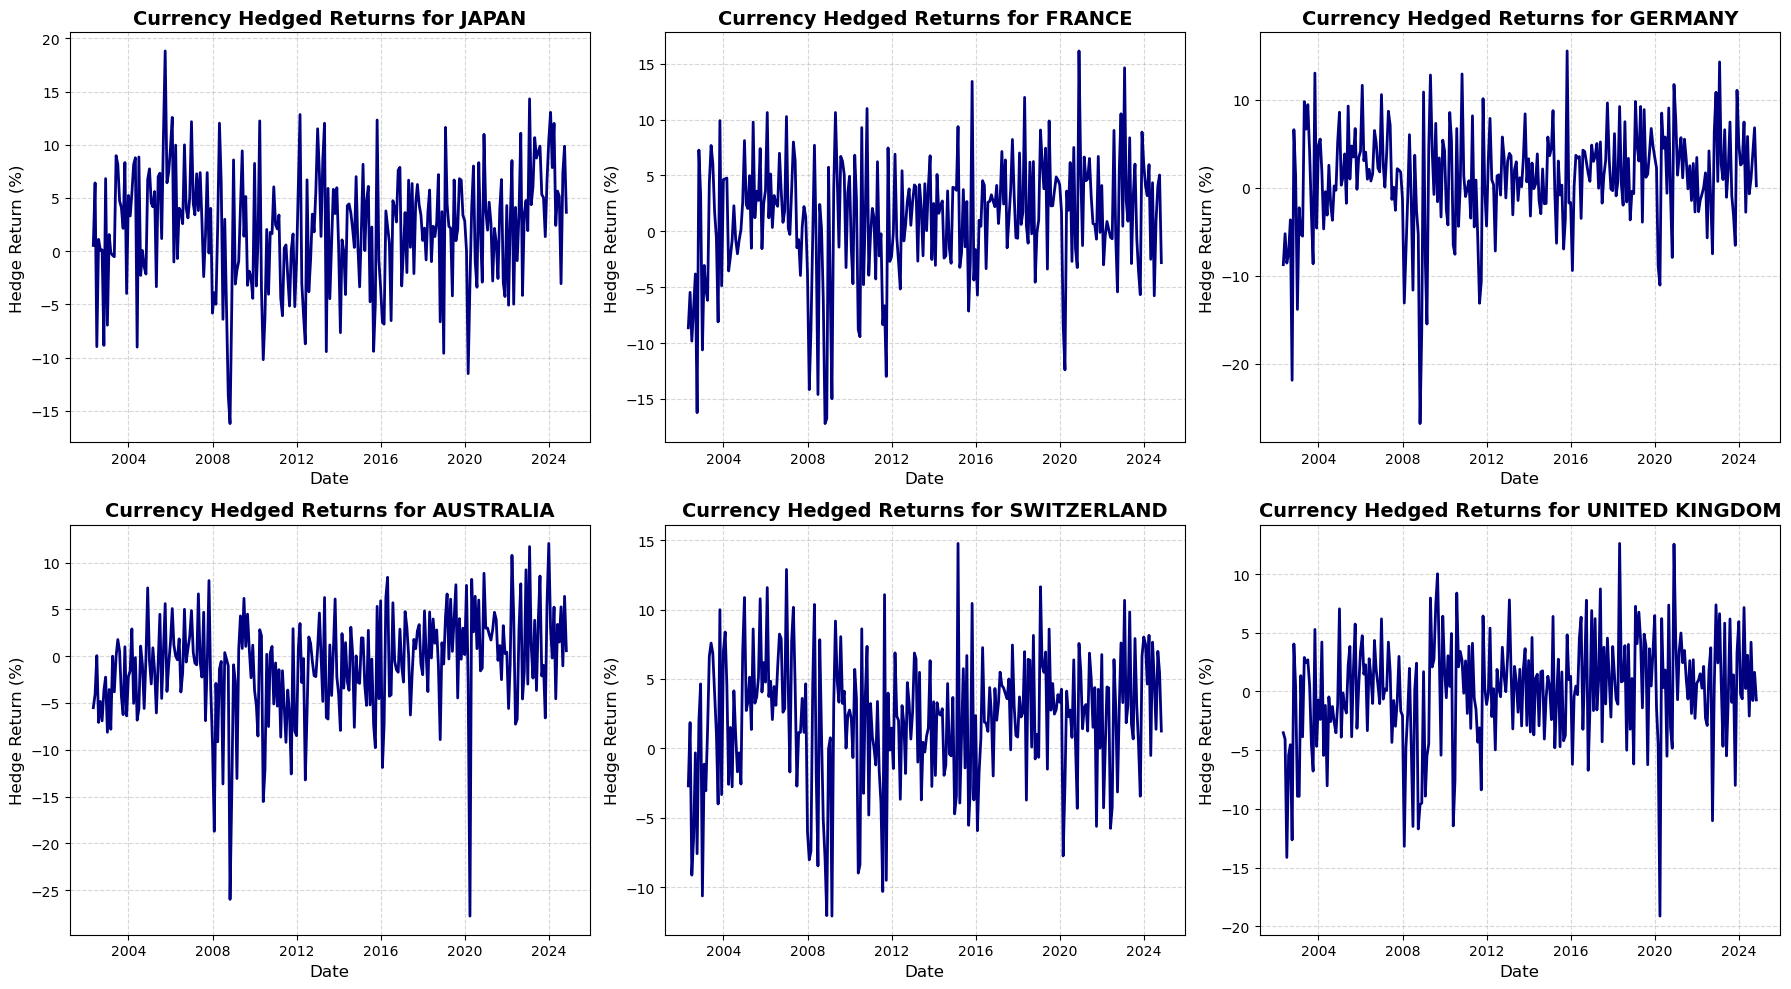

In [138]:
import matplotlib.pyplot as plt


countries = hedge_return.columns[:6] 
fig, axes = plt.subplots(2, 3, figsize=(18, 10))  
axes = axes.flatten()  

for i, country in enumerate(countries):
    ax = axes[i]
    ax.plot(hedge_return[country] * 100, color='navy', linewidth=2)
    ax.set_title(f'Currency Hedged Returns for {country.upper()}', fontsize=14, fontweight='bold')
    ax.set_xlabel('Date', fontsize=12)
    ax.set_ylabel('Hedge Return (%)', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.5)


for j in range(len(countries), 6):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


In [139]:
hedge_return.to_csv('data/q3/hedge_return.csv')

In [140]:
hedge_return.columns

Index(['JAPAN', 'FRANCE', 'GERMANY', 'AUSTRALIA', 'SWITZERLAND',
       'UNITED KINGDOM'],
      dtype='object')

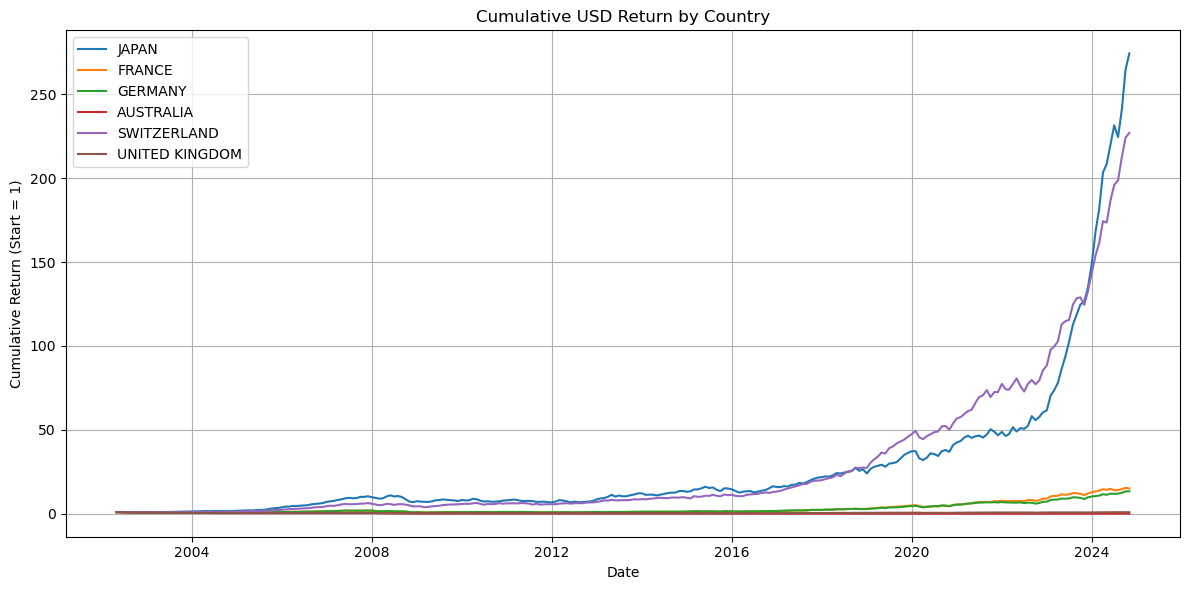

In [141]:
plt.figure(figsize=(12, 6))

# Plot cumulative returns for each country
for country in hedge_return.columns:
    cumulative = (1 + hedge_return[country]).cumprod()
    plt.plot(hedge_return.index, cumulative, label=country)

plt.title('Cumulative USD Return by Country')
plt.xlabel('Date')
plt.ylabel('Cumulative Return (Start = 1)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**C** •Equal weight the indexes No currency hedging

In [150]:
def evaluate_strategy_performance(strategy_return: pd.Series, Rf: pd.Series, name: str = "Strategy"):
    """
    Evaluate the performance of a strategy vs. the risk-free rate.
    
    Parameters:
    - strategy_return: pd.Series of monthly strategy returns (e.g., equal-weighted)
    - Rf: pd.Series of monthly risk-free rate (same units)
    - name: Optional name to use in the output
    """
    strategy_return = strategy_return.dropna()

    # Align both series
    common_dates = strategy_return.index.intersection(Rf.index)

    aligned_strategy = strategy_return.loc[common_dates]
    aligned_rf = Rf.loc[common_dates]
    
    # Compute excess returns
    excess_return = aligned_strategy.values - aligned_rf.values
    mean_excess = excess_return.mean()
    std_excess = excess_return.std()
    sharpe_annualized = (mean_excess / std_excess) * np.sqrt(12)

    print("-" * 50)
    print(f"Performance Summary for: {name}")
    print(f"Mean Monthly Excess Return   : {mean_excess:.5f}")
    print(f"Standard Deviation (Monthly) : {std_excess:.5f}")
    print(f"Annualized Sharpe Ratio      : {sharpe_annualized:.3f}")
    print("-" * 50)

In [151]:
pivoted = merged_all.pivot(index='date', columns='country', values='mportret')

equal_weight = pivoted.mean(axis=1)

In [152]:
evaluate_strategy_performance(equal_weight, Rf, name="Equal Weight Strategy")


--------------------------------------------------
Performance Summary for: Equal Weight Strategy
Mean Monthly Excess Return   : 0.00590
Standard Deviation (Monthly) : 0.04325
Annualized Sharpe Ratio      : 0.473
--------------------------------------------------


**C** •Equal weight the indexes currency hedging

In [153]:
equal_weight_hedged = hedge_return.mean(axis=1)
evaluate_strategy_performance(equal_weight_hedged, Rf,name = "Equal Weight Hedged Return Strategy")

--------------------------------------------------
Performance Summary for: Equal Weight Hedged Return Strategy
Mean Monthly Excess Return   : 0.00847
Standard Deviation (Monthly) : 0.04477
Annualized Sharpe Ratio      : 0.655
--------------------------------------------------


**C** •Risk-Parity based on a 60 months rolling window estimate of the strategy returns
volatilities

In [159]:
windowed_std = pivoted.rolling(window=60).std()
windowed_std.dropna(inplace=True)

rp_weights = 1/windowed_std

rp_weights_normalized = rp_weights.div(rp_weights.sum(axis=1), axis=0)


common_dates = pivoted.index.intersection(rp_weights_normalized.index)
aligned_extend_pivoted = pivoted.loc[common_dates]


value_portfolio = aligned_extend_pivoted*rp_weights_normalized

In [162]:
portfolio_returns = value_portfolio.sum(axis=1)

evaluate_strategy_performance(portfolio_returns, Rf,name='Risk parity strategy')

--------------------------------------------------
Performance Summary for: Risk parity strategy
Mean Monthly Excess Return   : 0.00436
Standard Deviation (Monthly) : 0.04399
Annualized Sharpe Ratio      : 0.343
--------------------------------------------------


**C** •Risk-Parity based on a 60 months rolling window estimate of the strategy returns
volatilities with currency hedge

In [290]:
windowed_std_hedge = hedge_return.rolling(window=60).std()
windowed_std_hedge.dropna(inplace=True)


rp_weights_hedge = 1 / windowed_std_hedge


rp_weights_hedge_normalized = rp_weights_hedge.div(rp_weights_hedge.sum(axis=1), axis=0)


common_dates_hedge = hedge_return.index.intersection(rp_weights_hedge_normalized.index)
aligned_extended_pivoted_hedge = hedge_return.loc[common_dates_hedge]

value_portfolio_hedge = aligned_extended_pivoted_hedge * rp_weights_hedge_normalized


In [291]:
risk_parity_returns_hedge = value_portfolio_hedge .sum(axis=1)

evaluate_strategy_performance(risk_parity_returns_hedge,  Rf,name='Risk parity strategy with currency hedge')

--------------------------------------------------
Performance Summary for: Risk parity strategy with currency hedge
Mean Monthly Excess Return   : 0.00874
Standard Deviation (Monthly) : 0.04442
Annualized Sharpe Ratio      : 0.681
--------------------------------------------------


**C** •Mean-variance optimal combination based on the rolling window mean and co-
variance matrix

In [223]:
def compute_tangency(cov_windowed, mean_windowed) : 
    tangency_weights = {}

    for date in mean_windowed.index:
        cov = cov_windowed.loc[date].to_numpy()
        mean = mean_windowed.loc[date]
        rf = Rf.loc[date].to_numpy()

        mu_excess = mean - rf  

        x, *_ = np.linalg.lstsq(cov, mu_excess, rcond=None)
        w = x / np.sum(x)

        tangency_weights[date] = pd.Series(w, index=mean.index)


    tangency_weights_df = pd.DataFrame(tangency_weights).T
    tangency_weights_df.index.name = 'date'
    tangency_weights_df.columns.name = 'country'



    common_dates = pivoted.index.intersection(tangency_weights_df.index)
    aligned_extend_pivoted = pivoted.loc[common_dates]


    value_portfolio = aligned_extend_pivoted *tangency_weights_df
    tangency_return = value_portfolio .sum(axis=1)

    return tangency_return

In [224]:
mean_windowed = pivoted.rolling(window=60).mean()
cov_windowed  = pivoted.rolling(window=60).cov()

mean_windowed.dropna(inplace=True)
cov_windowed.dropna(inplace=True)


tangency_return =  compute_tangency(cov_windowed, mean_windowed)

evaluate_strategy_performance(tangency_return , Rf,name='Tangency portfolio without currency hedge')

--------------------------------------------------
Performance Summary for: Tangency portfolio without currency hedge
Mean Monthly Excess Return   : -0.07097
Standard Deviation (Monthly) : 1.12893
Annualized Sharpe Ratio      : -0.218
--------------------------------------------------


In [ ]:

mean_windowed = hedge_return.rolling(window=60).mean()
cov_windowed = hedge_return.rolling(window=60).cov()

mean_windowed.dropna(inplace=True)
cov_windowed.dropna(inplace=True)

tangency_return_hedged =  compute_tangency(cov_windowed, mean_windowed)


evaluate_strategy_performance(tangency_return_hedged, Rf, name='Tangency currency hedged strategy')


--------------------------------------------------
Performance Summary for: Tangency currency hedged strategy
Mean Monthly Excess Return   : 0.01085
Standard Deviation (Monthly) : 0.43088
Annualized Sharpe Ratio      : 0.087
--------------------------------------------------


**4 Equity Index Momentum Strategy (MOM)** 

### Momentum Weight Derivation and Normalization

We define the weight for country \( i \) at time \( t \) as:

$
w_t^i = Z \left( \text{Rank}_t^i - \frac{N + 1}{2} \right)
$



In [302]:
lagged_return = hedge_return.shift(1).rolling(window=11).apply(lambda x: np.prod(1 + x), raw=True)
lagged_return.dropna(inplace=True)


ranks = lagged_return.rank(axis=1, method='first')


N = hedge_return.shape[1]
rank_center = (N + 1) / 2

position = ranks - rank_center

long = position.where(position > 0, 0)
short = position.where(position < 0, 0)

long_weight = long.div(long.sum(axis=1), axis=0)
short_weight = short.div(short.sum(axis=1), axis=0)


weights = long_weight.fillna(0) - short_weight.fillna(0)



common_dates_hedge = hedge_return.index.intersection(weights.index)
aligned_extended_pivoted_hedge = hedge_return.loc[common_dates_hedge]
weights = weights.loc[common_dates_hedge]

mom = aligned_extended_pivoted_hedge * weights


mom = mom.sum(axis=1)

evaluate_strategy_performance(mom, Rf, name='Equity Index Momentum Strategy')


--------------------------------------------------
Performance Summary for: Equity Index Momentum Strategy
Mean Monthly Excess Return   : 0.01904
Standard Deviation (Monthly) : 0.03342
Annualized Sharpe Ratio      : 1.973
--------------------------------------------------


**Now let's analyze for the short and long strategy independently**

In [303]:
long_leg_strat = aligned_extended_pivoted_hedge * long_weight

long_leg_strat = long_leg_strat.sum(axis=1)


evaluate_strategy_performance(long_leg_strat, Rf, name='Equity Index Momentum Strategy only the Long leg')

--------------------------------------------------
Performance Summary for: Equity Index Momentum Strategy only the Long leg
Mean Monthly Excess Return   : 0.01937
Standard Deviation (Monthly) : 0.04657
Annualized Sharpe Ratio      : 1.441
--------------------------------------------------


In [304]:
short_leg_strat = aligned_extended_pivoted_hedge * short_weight

short_leg_strat = short_leg_strat.sum(axis=1)


evaluate_strategy_performance(short_leg_strat, Rf, name='Equity Index Momentum Strategy only the Short leg')

--------------------------------------------------
Performance Summary for: Equity Index Momentum Strategy only the Short leg
Mean Monthly Excess Return   : -0.00091
Standard Deviation (Monthly) : 0.04629
Annualized Sharpe Ratio      : -0.068
--------------------------------------------------


In [305]:
from scipy import stats

def test_mean_nonzero(series, alpha=0.05):
    t_stat, p_value = stats.ttest_1samp(series, 0)

    if p_value < alpha:
        print(f"The strategy average return is significant at alpha = {alpha}, so we can reject the null hypothesis that the mean is 0.")
    else:
        print(f"The strategy average return is not significant at alpha = {alpha}, so we cannot reject the null hypothesis that the mean is 0.")


In [306]:
test_mean_nonzero(mom)

The strategy average return is significant at alpha = 0.05, so we can reject the null hypothesis that the mean is 0.


In [316]:
import statsmodels.api as sm


common_dates_hedge = mom.index.intersection(risk_parity_returns_hedge.index)
aligned_mom = mom.loc[common_dates_hedge]
aligned_risk = risk_parity_returns_hedge.loc[common_dates_hedge]

y = aligned_mom
X = aligned_risk
X = sm.add_constant(X) 

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.462
Date:                Fri, 30 May 2025   Prob (F-statistic):              0.228
Time:                        19:16:25   Log-Likelihood:                 423.77
No. Observations:                 212   AIC:                            -843.5
Df Residuals:                     210   BIC:                            -836.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0167      0.002      7.228      0.0

The MOM strategy delivers significant positive alpha, meaning it adds return beyond what DIV explains The insignificant beta implies low correlation with DIV hence, there is a diversification benefit.

Combining them may improve the maximum Sharpe ratio of the total portfolio.

**5. Equity Index Long Term Reversal strategy (REV)**

In [320]:
lagged_return_rev = hedge_return.shift(12).rolling(window=49).apply(lambda x: np.prod(1 + x), raw=True)


ranks = lagged_return_rev.rank(axis=1, method='first')


N = hedge_return.shape[1]
rank_center = (N + 1) / 2

position = ranks - rank_center

long = position.where(position > 0, 0)
short = position.where(position < 0, 0)

long_weight = long.div(long.sum(axis=1), axis=0)
short_weight = short.div(short.sum(axis=1), axis=0)


weights = long_weight.fillna(0) - short_weight.fillna(0)



common_dates_hedge = hedge_return.index.intersection(weights.index)
aligned_extended_pivoted_hedge = hedge_return.loc[common_dates_hedge]
weights = weights.loc[common_dates_hedge]

rev = aligned_extended_pivoted_hedge * weights


rev = rev.sum(axis=1)

evaluate_strategy_performance(rev, Rf, name='Equity Index Long Term Reversal Strategy')


--------------------------------------------------
Performance Summary for: Equity Index Long Term Reversal Strategy
Mean Monthly Excess Return   : 0.01278
Standard Deviation (Monthly) : 0.02845
Annualized Sharpe Ratio      : 1.556
--------------------------------------------------


In [321]:
long_leg_strat = aligned_extended_pivoted_hedge * long_weight

long_leg_strat = long_leg_strat.sum(axis=1)


evaluate_strategy_performance(long_leg_strat, Rf, name='Equity Index Momentum Strategy only the Long leg')

--------------------------------------------------
Performance Summary for: Equity Index Momentum Strategy only the Long leg
Mean Monthly Excess Return   : 0.01168
Standard Deviation (Monthly) : 0.04023
Annualized Sharpe Ratio      : 1.005
--------------------------------------------------


In [322]:
short_leg_strat = aligned_extended_pivoted_hedge * short_weight

short_leg_strat = short_leg_strat.sum(axis=1)


evaluate_strategy_performance(short_leg_strat, Rf, name='Equity Index Momentum Strategy only the Short leg')

--------------------------------------------------
Performance Summary for: Equity Index Momentum Strategy only the Short leg
Mean Monthly Excess Return   : -0.00235
Standard Deviation (Monthly) : 0.04278
Annualized Sharpe Ratio      : -0.190
--------------------------------------------------


In [323]:
import statsmodels.api as sm


common_dates_hedge = mom.index.intersection(risk_parity_returns_hedge.index)
aligned_rev = rev.loc[common_dates_hedge]
aligned_risk = risk_parity_returns_hedge.loc[common_dates_hedge]

y = aligned_rev
X = aligned_risk
X = sm.add_constant(X) 

model = sm.OLS(y, X)
results = model.fit()

print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                  0.010
Method:                 Least Squares   F-statistic:                     3.035
Date:                Fri, 30 May 2025   Prob (F-statistic):             0.0830
Time:                        19:40:07   Log-Likelihood:                 436.82
No. Observations:                 212   AIC:                            -869.6
Df Residuals:                     210   BIC:                            -862.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0188      0.002      8.636      0.0

A DIV investor should definitely consider allocating to the rev strategy, it provides strong alpha and low correlation with existing exposures.